In [264]:
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [265]:
CO_dataset = pd.read_csv('../DataBases/crude_oil.csv')
CO_dataset.rename(columns={' Value': 'value' },inplace=True)
CO_dataset.dropna(inplace=True)
Crude_Series = CO_dataset.value.values



FUNÇÃO DE AGRUPAMENTO DE DADOS


In [266]:
def group(dataset:pd.DataFrame, period: str = 'm')-> pd.DataFrame:
    dataset.Date = pd.to_datetime(dataset.Date)
    Year = dataset.Date.dt.year
    month= dataset.Date.dt.month
    week= dataset.Date.dt.isocalendar().week
    grouped_df =dataset.copy()

    if period== 'm':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df=grouped_df.groupby(['Year', 'Month']).mean()

        grouped_df['Date'] = [f'{year}-{month}' for year, month in grouped_df.index]
        
    elif period== 'w':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df['Week'] = week
        grouped_df=grouped_df.groupby(['Year', 'Month', 'week']).mean()

        grouped_df['Date'] = [f'{year}-{month}-{week}' for year, month, week in grouped_df.index]

    return grouped_df

Chamando a função AR


In [267]:
def Ar(dataset:pd.DataFrame, lags: int=1) -> dict:
    from sklearn.metrics import mean_absolute_error
    from statsmodels.tsa.ar_model import AutoReg as AR

    train = dataset[:-2]
    test = dataset[-3:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        model = AR(history, lags=lags)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    mae = (mean_absolute_error(test, predictions))
    return (model_fit,  mae, test, predictions)

In [268]:
def grid_search_model(dataset: list, lags_list: list):
    from statsmodels.tsa.ar_model import AutoReg

    best_score, lags = 0, None
    for lag in lags_list:
                try:
                    AIC = AutoReg(dataset, lags=lag).fit().aic
                    if AIC > best_score:
                        best_score = AIC
                        lags = lag
                        print(
                            f'AR{lags}, AIC= {best_score}'
                        )
                except:
                    continue
    print(f'BEST AR({lags}), AIC= {best_score}')
    return(lags, best_score)

C:\Users\User\AppData\Local\Temp\ipykernel_10532\997464697.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df=grouped_df.groupby(['Year', 'Month']).mean()


AR1, AIC= 102.1517423354182
BEST AR(1), AIC= 102.1517423354182


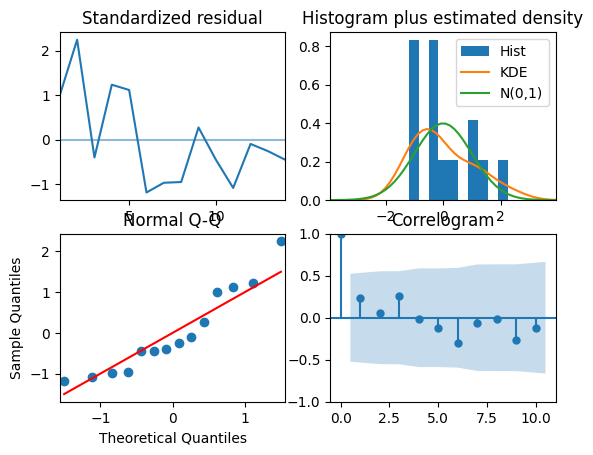

In [288]:
Crude_Series = group(CO_dataset).reset_index()

best_config, best_score = grid_search_model(Crude_Series.value.values, lags_list= [1,2,3,4,5, 10])

model_fit, mae, test, predictions  = Ar(Crude_Series.value.values, lags=best_config)

model_fit.plot_diagnostics()
plt.show()

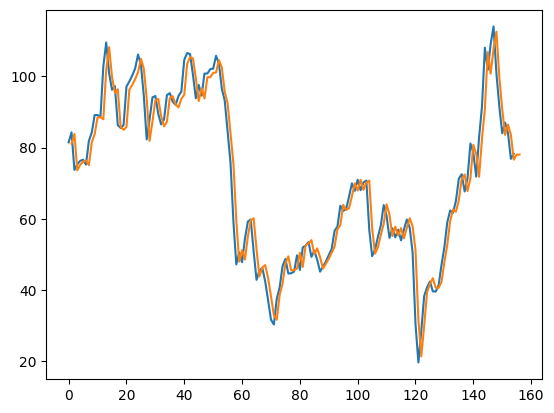

In [272]:
sns.lineplot(Crude_Series.value.values[:-2])
sns.lineplot(model_fit.predict()[:])
plt.show()

In [273]:
error = Crude_Series.value.values[1:] - model_fit.predict()[1:]


<Axes: >

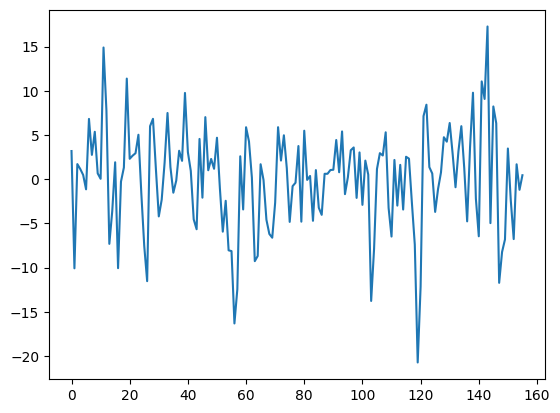

In [274]:
sns.lineplot(error)

In [275]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(Crude_Series.value.values[1:],model_fit.predict()[1:])
mape = mean_absolute_percentage_error(Crude_Series.value.values[1:],model_fit.predict()[1:])

print(f'mae: {mae}, mape: {mape}')

mae: 4.376741667592334, mape: 0.07101443843464852


BASE DE TESTE

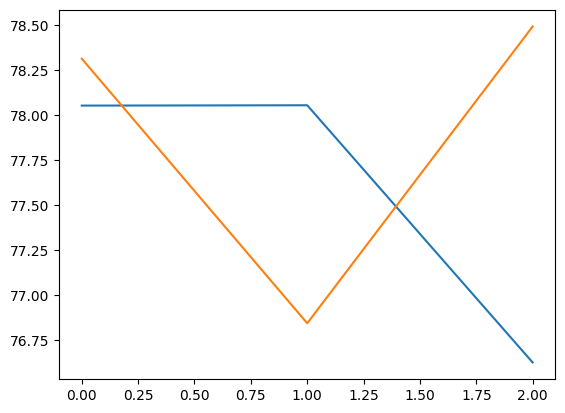

In [276]:
sns.lineplot(predictions)
sns.lineplot(test)
plt.show()

In [277]:
mae = mean_absolute_error(predictions,test)
mape = mean_absolute_percentage_error(predictions,test)

print(f'mae: {mae}, mape: {mape}')

mae: 1.1118930005999441, mape: 0.014393418205568739


<Axes: >

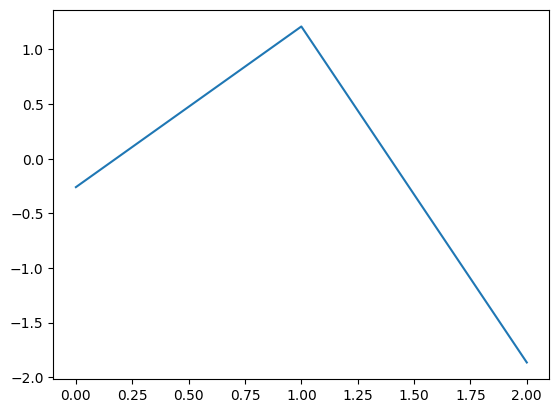

In [278]:
resíduo = predictions - test
sns.lineplot(resíduo)

CREATING AN EXCEL FILE WITH THE RESULTS

In [279]:
Avaliation

value     Date  Model_fit  Test_Predictions  mae_base_test  \
Year Month                                                                   
2010 3      81.485000   2010-3  71.286452               NaN       6.636204   
     4      84.292857   2010-4  71.286452               NaN            NaN   
     5      73.743500   2010-5  71.286452               NaN            NaN   
     6      75.335909   2010-6  71.286452               NaN            NaN   
     7      76.319524   2010-7  71.286452               NaN            NaN   
...               ...      ...        ...               ...            ...   
2022 11     84.085000  2022-11  71.286452               NaN            NaN   
     12     76.848636  2022-12  71.286452               NaN            NaN   
2023 1      78.313636   2023-1  71.286452         71.205253            NaN   
     2      76.845000   2023-2  71.286452         71.250820            NaN   
     3      78.492500   2023-3  71.286452         71.286452            NaN   

            mape_base_test  mae_train_base  mape_train_base  
Year Month                                                   
2010 3            0.093143        19.84196         0.333329  
     4                 NaN             NaN              NaN  
     5                 NaN             NaN              NaN  
     6                 NaN             NaN              NaN  
     7                 NaN             NaN              NaN  
...                    ...             ...              ...  
2022 11                NaN             NaN              NaN  
     12                NaN             NaN              NaN  
2023 1                 NaN             NaN              NaN  
     2                 NaN             NaN              NaN  
     3                 NaN             NaN              NaN  

[157 rows x 8 columns]

In [280]:
from openpyxl import Workbook
import pandas as pd
import openpyxl

In [281]:
Avaliation = Crude_Series.copy()
Avaliation['Model_fit'] = model_fit.predict()
Avaliation['Test_Predictions'] = [None for x in model_fit.predict()[3:]] + predictions

mae_test = [mean_absolute_error(predictions,test)]
mape_test = [mean_absolute_percentage_error(predictions,test)]
mae_train_base = [mean_absolute_error(Crude_Series.value.values[1:],model_fit.predict()[1:])]
mape_train_base = [mean_absolute_percentage_error(Crude_Series.value.values[1:],model_fit.predict()[1:])]


mae_test_list = mae_test + [None for i in range(len(Avaliation.value.values)-1)]
mape_test_list = mape_test + [None for i in range(len(Avaliation.value.values)-1)]

mae_train_list = mae_train_base + [None for i in range(len(Avaliation.value.values)-1)]
mape_train_list = mape_train_base + [None for i in range(len(Avaliation.value.values)-1)]

Avaliation['mae_base_test'] = mae_test_list
Avaliation['mape_base_test'] = mape_test_list
Avaliation['mae_train_base'] = mae_train_list
Avaliation['mape_train_base'] = mape_train_list


    

Avaliation
Avaliation.to_csv('file34.csv', header=True, index=True)


In [282]:
Avaliation

value     Date  Model_fit  Test_Predictions  mae_base_test  \
Year Month                                                                   
2010 3      81.485000   2010-3        NaN               NaN       1.111893   
     4      84.292857   2010-4  81.111409               NaN            NaN   
     5      73.743500   2010-5  83.824927               NaN            NaN   
     6      75.335909   2010-6  73.630007               NaN            NaN   
     7      76.319524   2010-7  75.168915               NaN            NaN   
...               ...      ...        ...               ...            ...   
2022 11     84.085000  2022-11  86.492657               NaN            NaN   
     12     76.848636  2022-12  83.624054               NaN            NaN   
2023 1      78.313636   2023-1  76.630817         78.053269            NaN   
     2      76.845000   2023-2  78.046596         78.055115            NaN   
     3      78.492500   2023-3  78.046596         76.627303            NaN   

            mape_base_test  mae_train_base  mape_train_base  
Year Month                                                   
2010 3            0.014393        4.376742         0.071014  
     4                 NaN             NaN              NaN  
     5                 NaN             NaN              NaN  
     6                 NaN             NaN              NaN  
     7                 NaN             NaN              NaN  
...                    ...             ...              ...  
2022 11                NaN             NaN              NaN  
     12                NaN             NaN              NaN  
2023 1                 NaN             NaN              NaN  
     2                 NaN             NaN              NaN  
     3                 NaN             NaN              NaN  

[157 rows x 8 columns]

In [283]:
Avaliation

value     Date  Model_fit  Test_Predictions  mae_base_test  \
Year Month                                                                   
2010 3      81.485000   2010-3        NaN               NaN       1.111893   
     4      84.292857   2010-4  81.111409               NaN            NaN   
     5      73.743500   2010-5  83.824927               NaN            NaN   
     6      75.335909   2010-6  73.630007               NaN            NaN   
     7      76.319524   2010-7  75.168915               NaN            NaN   
...               ...      ...        ...               ...            ...   
2022 11     84.085000  2022-11  86.492657               NaN            NaN   
     12     76.848636  2022-12  83.624054               NaN            NaN   
2023 1      78.313636   2023-1  76.630817         78.053269            NaN   
     2      76.845000   2023-2  78.046596         78.055115            NaN   
     3      78.492500   2023-3  78.046596         76.627303            NaN   

            mape_base_test  mae_train_base  mape_train_base  
Year Month                                                   
2010 3            0.014393        4.376742         0.071014  
     4                 NaN             NaN              NaN  
     5                 NaN             NaN              NaN  
     6                 NaN             NaN              NaN  
     7                 NaN             NaN              NaN  
...                    ...             ...              ...  
2022 11                NaN             NaN              NaN  
     12                NaN             NaN              NaN  
2023 1                 NaN             NaN              NaN  
     2                 NaN             NaN              NaN  
     3                 NaN             NaN              NaN  

[157 rows x 8 columns]